<a href="https://colab.research.google.com/github/vsbca/Data-Science/blob/master/Mitre_TTPs_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Agenda**
1. Quick Mitre Introduction
2. Mitre Mappingin Logs

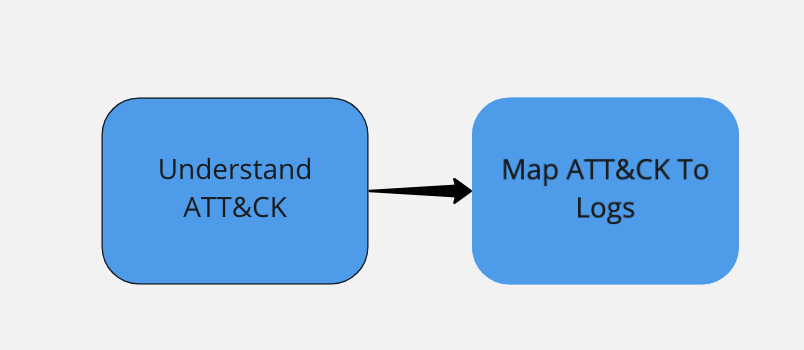


Why mitre ATT&CK mapping, before we jump to the introduction? <br/><br/>

SOC need to answer below questions in their day to data job <br/><br/>
  **▪ How effective are my defenses?<br/>**
  **▪ Do I have a chance at detecting any new/updated APT. Example:APT29?<br/>**
  **▪ Is the data sources, I’m collecting useful?<br/>**
  **▪ Do I have overlapping tool coverage?<br/>**
  **▪ Will this new product help my organization’s defenses?<br/>**


# **Mitre ATT&CK:**
<br/>
MITRE introduced ATT&CK (Adversarial Tactics, Techniques & Common Knowledge) in 2013 as a way to describe and categorize adversarial behaviors based on real-world observations. ATT&CK is a structured list of known attacker behaviors that have been compiled into tactics and techniques and expressed in a handful of matrices as well as via STIX/TAXII. 

<br/>
<br/>
When looking at ATT&CK in the form of a matrix, the column titles across the top are tactics and are essentially categories of techniques. <b>Tactics</b> are the what attackers are trying to achieve whereas the individual <b>techniques </b>are the how they accomplish those steps or goals.

<br/>
<br/>

#   **A knowledge base of adversary behavior**
*   Based on real-world observations
*   Free, open, and globally accessible
*   A common language
*   Community-driven







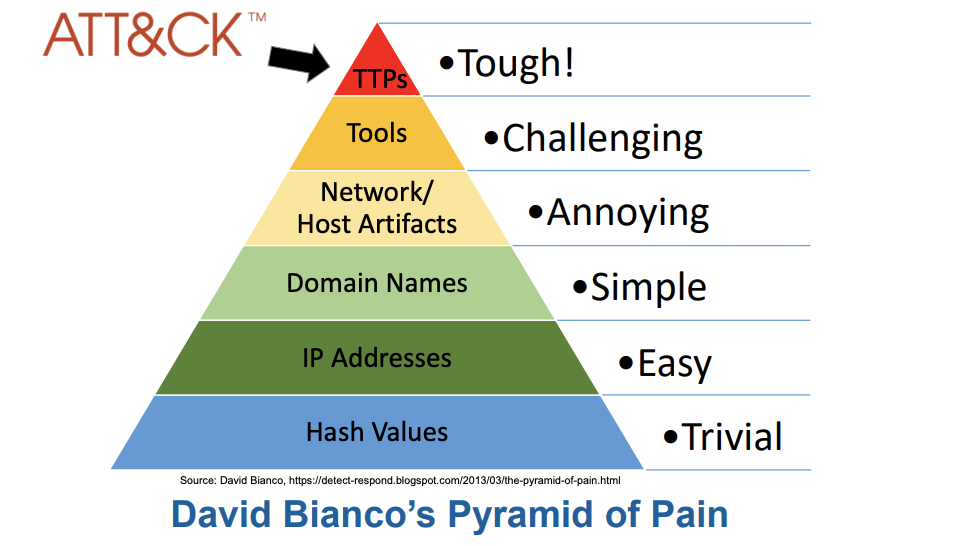

Ref:
https://detect-respond.blogspot.com/2013/03/the-pyramid-of-pain.html


# Mitre Stats:
**Tactics: 14**
**Technique: #**
**Sub-Technique: #**

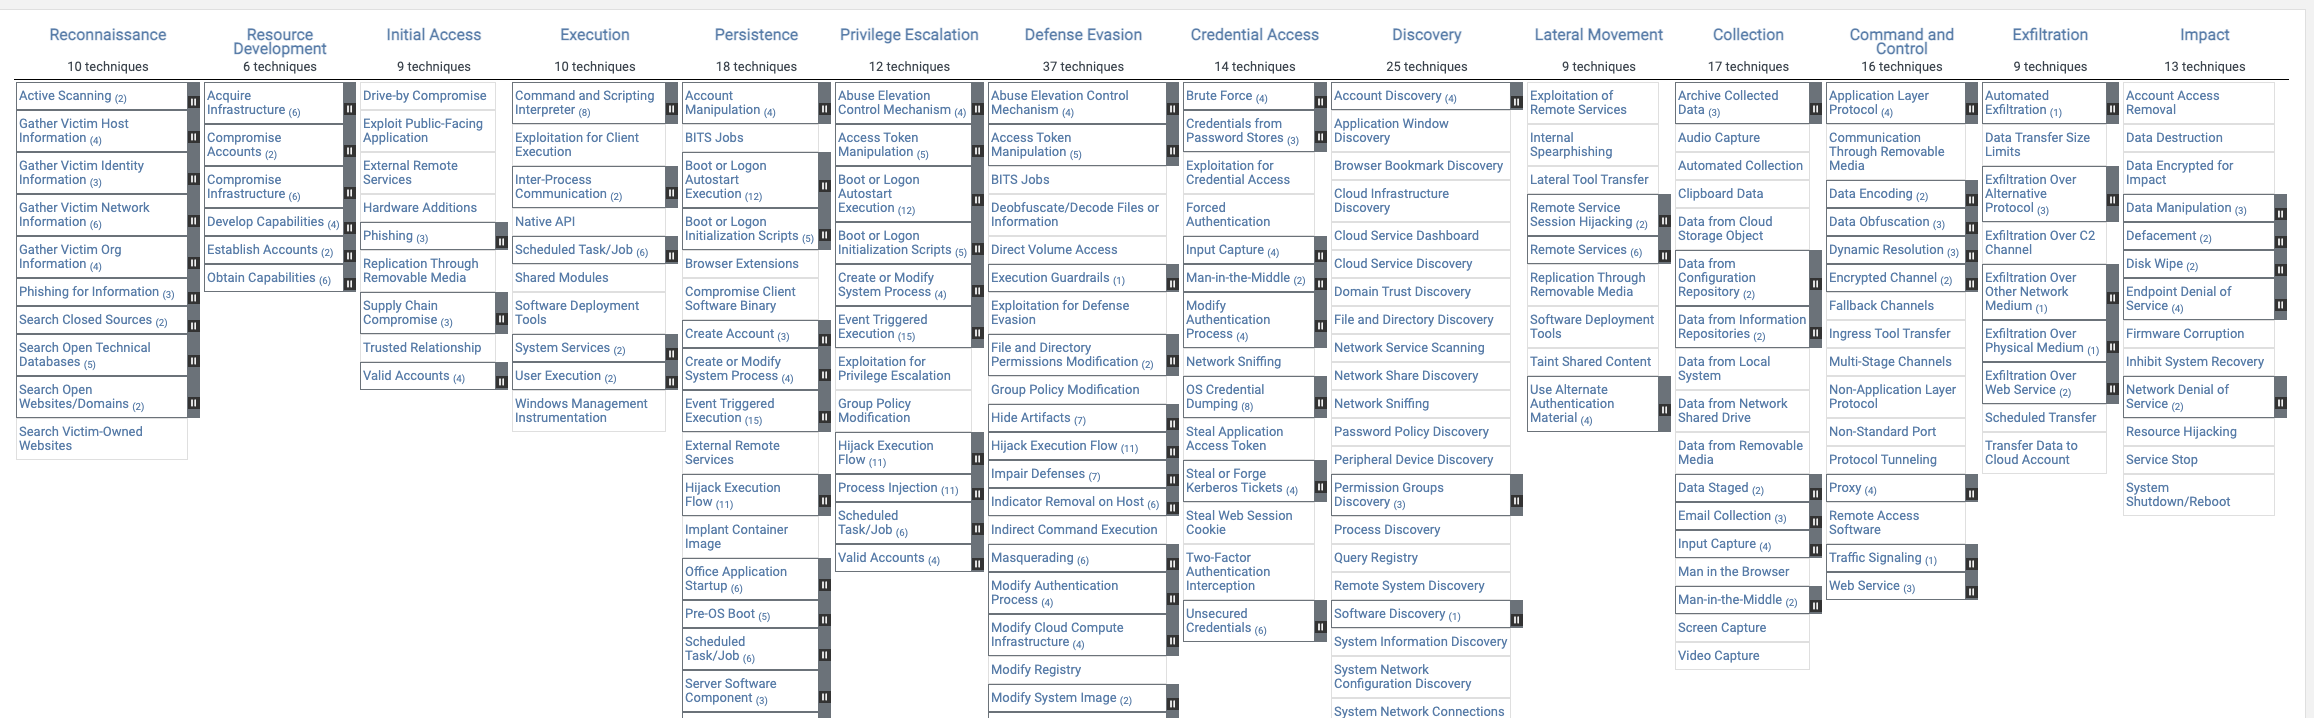
Ref:
https://attack.mitre.org/


# **Why Is it Difficult to Map Logs to ATT&CK**

*   Requires a shift in Analyst thinking <br/>
    - Indicators > behaviors <br/>
*   Volume of ATT&CK techniques <br/>
*   "Technical" details of some ATT&CK techniques <br/>







# **But it’s worthwhile because this process…**


*   Forces analysts to shift to thinking about behaviors
*   Allows them to learn about new adversary techniques
*   Pushes them to learn the “technical” side
*   Enable them to detect new unknown threats, because adversady can change IOCs not TTPs so easily.





# **Process of Mapping to ATT&CK**
 1. **Understand ATT&CK** <br/>
 2. **Find the behavior** <br/>
 3. Research the behavior<br/>
 4. Translate the behavior into a tactic<br/>
 5. Figure out what technique applies to the behavior<br/>
 6. Compare your results to other analysts<br/>

# Understand ATT&CK
You need to know what to look for before you can do this <br/>
▪ To get started: <br/>
  – Watch an ATT&CK presentation like Sp4rkcon <br/>
  – Read the research/technical Papers from our Getting Started page <br/>
  – Read the Tactic descriptions<br/>
  – Skim the Techniques list<br/>


# **Find the Behavior**
1. **Different mindset from looking for indicators:**<br/>
      ▪ Look for what the adversary or software does <br/>
      ▪ Focus on initial compromise and post-compromise details <br/>


2. **Info that may not be useful for ATT&CK mapping:** <br/>
      ▪ Static malware analysis<br/>
      ▪ Infrastructure registration information<br/>
      ▪ Industry/victim targeting information<br/>

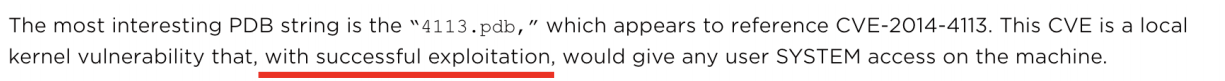

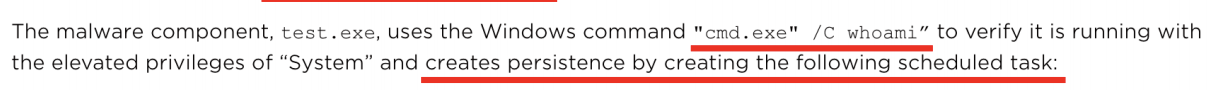

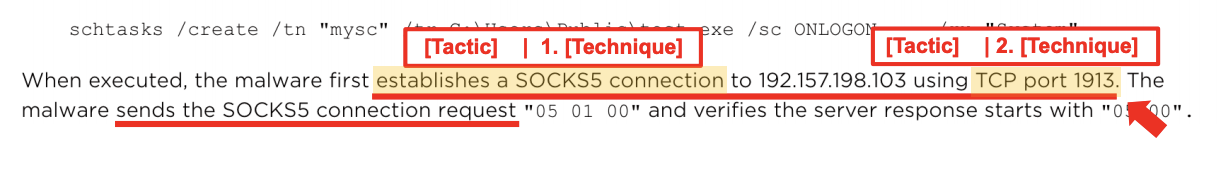

Ref:
https://www.fireeye.com/blog/threat-research/2014/11/operation_doubletap.html


In [1]:
!pip install attackcti

     |████████████████████████████████| 163kB 8.4MB/s 
     |████████████████████████████████| 133kB 11.4MB/s 
     |████████████████████████████████| 71kB 6.5MB/s 
     |████████████████████████████████| 112kB 11.3MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-cp36-none-any.whl size=141230 sha256=de3500f01ac6c9c01cfb0fde5a276632673b18e9785059b4983142b13f7a2a48
  Stored in directory: /root/.cache/pip/wheels/e3/e2/fa/b78480b448b8579ddf393bebd3f47ee23aa84c89b6a78285c8
Successfully built antlr4-python3-runtime


In [2]:
!pip install altair

In [3]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow.python.lib.io import file_io
import numpy as np
import sys
from pandas.io.json import json_normalize
from attackcti import attack_client

import altair as alt
alt.renderers.enable('default')
import itertools


In [4]:
att_ck = attack_client()

In [5]:
all_ttps = att_ck.get_enterprise_techniques(stix_format=False)

In [6]:
all_ttps[0]

{'created': '2020-10-20T00:09:33.072Z',
 'created_by_ref': 'identity--c78cb6e5-0c4b-4611-8297-d1b8b55e40b5',
 'data_sources': ['Network device logs',
  'Network device run-time memory',
  'Network device command history',
  'Network device configuration'],
 'external_references': [{'external_id': 'T1059.008',
   'source_name': 'mitre-attack',
   'url': 'https://attack.mitre.org/techniques/T1059/008'},
  {'description': 'Graham Holmes. (2015, October 8). Evolution of attacks on Cisco IOS devices. Retrieved October 19, 2020.',
   'source_name': 'Cisco Synful Knock Evolution',
   'url': 'https://blogs.cisco.com/security/evolution-of-attacks-on-cisco-ios-devices'},
  {'description': 'Cisco. (n.d.). Cisco IOS Software Integrity Assurance - Command History. Retrieved October 21, 2020.',
   'source_name': 'Cisco IOS Software Integrity Assurance - Command History',
   'url': 'https://tools.cisco.com/security/center/resources/integrity_assurance.html#23'}],
 'id': 'attack-pattern--818302b2-d640

In [8]:
#Normalize
ttp_normalized = json_normalize(all_ttps)
ttp_normalized[0:1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,external_references,kill_chain_phases,x_mitre_is_subtechnique,x_mitre_version,id,technique_description,technique,created_by_ref,object_marking_refs,url,matrix,technique_id,type,tactic,modified,created,data_sources,platform,technique_detection,permissions_required,defense_bypassed,capec_id,capec_url,contributors,system_requirements,network_requirements,effective_permissions,remote_support,impact_type,revoked,x_mitre_deprecated
0,"[{'source_name': 'mitre-attack', 'external_id'...","[{'kill_chain_name': 'mitre-attack', 'phase_na...",True,1.0,attack-pattern--818302b2-d640-477b-bf88-873120...,Adversaries may abuse scripting or built-in co...,Network Device CLI,identity--c78cb6e5-0c4b-4611-8297-d1b8b55e40b5,[marking-definition--fa42a846-8d90-4e51-bc29-7...,https://attack.mitre.org/techniques/T1059/008,mitre-attack,T1059.008,attack-pattern,[execution],2020-10-22T16:43:38.388Z,2020-10-20T00:09:33.072Z,"[Network device logs, Network device run-time ...",[Network],Consider reviewing command history in either t...,"[Administrator, User]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#Re-Indexing the Dataframe
pd.set_option(
    'display.max_colwidth', 1000
)
techniques = ttp_normalized.reindex(['matrix','platform','tactic','technique','technique_id','data_sources'], axis=1)

In [12]:
techniques.head(3)

,matrix,platform,tactic,technique,technique_id,data_sources
0,mitre-attack,[Network],[execution],Network Device CLI,T1059.008,"[Network device logs, Network device run-time memory, Network device command history, Network device configuration]"
1,mitre-attack,[Network],[collection],Network Device Configuration Dump,T1602.002,"[Netflow/Enclave netflow, Network protocol analysis, Packet capture]"
2,mitre-attack,[Network],"[defense-evasion, persistence]",TFTP Boot,T1542.005,"[Network device run-time memory, Network device command history, Network device configuration, File monitoring, Network device logs]"


In [15]:
##List the Spearch phishing technique
ttp_normalized[ttp_normalized["technique_id"] == "T1566.001"]

,external_references,kill_chain_phases,x_mitre_is_subtechnique,x_mitre_version,id,technique_description,technique,created_by_ref,object_marking_refs,url,matrix,technique_id,type,tactic,modified,created,data_sources,platform,technique_detection,permissions_required,defense_bypassed,capec_id,capec_url,contributors,system_requirements,network_requirements,effective_permissions,remote_support,impact_type,revoked,x_mitre_deprecated
191,"[{'source_name': 'mitre-attack', 'external_id': 'T1566.001', 'url': 'https://attack.mitre.org/techniques/T1566/001'}, {'external_id': 'CAPEC-163', 'source_name': 'capec', 'url': 'https://capec.mitre.org/data/definitions/163.html'}]","[{'kill_chain_name': 'mitre-attack', 'phase_name': 'initial-access'}]",True,2.0,attack-pattern--2e34237d-8574-43f6-aace-ae2915de8597,"Adversaries may send spearphishing emails with a malicious attachment in an attempt to gain access to victim systems. Spearphishing attachment is a specific variant of spearphishing. Spearphishing attachment is different from other forms of spearphishing in that it employs the use of malware attached to an email. All forms of spearphishing are electronically delivered social engineering targeted at a specific individual, company, or industry. In this scenario, adversaries attach a file to the spearphishing email and usually rely upon [User Execution](https://attack.mitre.org/techniques/T1204) to gain execution.\n\nThere are many options for the attachment such as Microsoft Office documents, executables, PDFs, or archived files. Upon opening the attachment (and potentially clicking past protections), the adversary's payload exploits a vulnerability or directly executes on the user's system. The text of the spearphishing email usually tries to give a plausible reason why the file sho...",Spearphishing Attachment,identity--c78cb6e5-0c4b-4611-8297-d1b8b55e40b5,[marking-definition--fa42a846-8d90-4e51-bc29-71d5b4802168],https://attack.mitre.org/techniques/T1566/001,mitre-attack,T1566.001,attack-pattern,[initial-access],2020-10-18T01:52:25.316Z,2020-03-02T19:05:18.137Z,"[File monitoring, Packet capture, Network intrusion detection system, Detonation chamber, Email gateway, Mail server]","[macOS, Windows, Linux]","Network intrusion detection systems and email gateways can be used to detect spearphishing with malicious attachments in transit. Detonation chambers may also be used to identify malicious attachments. Solutions can be signature and behavior based, but adversaries may construct attachments in a way to avoid these systems.\n\nAnti-virus can potentially detect malicious documents and attachments as they're scanned to be stored on the email server or on the user's computer. Endpoint sensing or network sensing can potentially detect malicious events once the attachment is opened (such as a Microsoft Word document or PDF reaching out to the internet or spawning Powershell.exe) for techniques such as [Exploitation for Client Execution](https://attack.mitre.org/techniques/T1203) or usage of malicious scripts.",NaN,NaN,CAPEC-163,https://capec.mitre.org/data/definitions/163.html,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
#Total number of tecniques
print('Total of ',len(techniques),' techniques')

Total of  665  techniques


In [ ]:
#Group
data = techniques
data_2 = data.groupby(['matrix'])['technique'].count()
data_3 = data_2.to_frame().reset_index()
data_3

,matrix,technique
0,mitre-attack,665


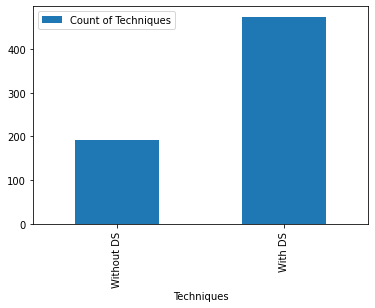

In [ ]:
#Techniques without DataSources

data_source_distribution = pd.DataFrame({
    'Techniques': ['Without DS','With DS'],
    'Count of Techniques': [techniques['data_sources'].isna().sum(),techniques['data_sources'].notna().sum()]})

#bars = alt.Chart(data_source_distribution).mark_bar().encode(x='Techniques',y='Count of Techniques',color='Techniques').properties(width=200,height=300)
#text = bars.mark_text(align='center',baseline='middle',dx=0,dy=-5).encode(text='Count of Techniques')
#bars + text
import matplotlib.pyplot as plt
data_source_distribution.plot(kind="bar", x=  'Techniques', y = 'Count of Techniques')
plt.show()

In [ ]:
#Count
data = techniques
data['Count_DS'] = data['data_sources'].str.len()
data['Ind_DS'] = np.where(data['Count_DS']>0,'With DS','Without DS')
data_2 = data.groupby(['matrix','Ind_DS'])['technique'].count()
data_3 = data_2.to_frame().reset_index()
data_3

,matrix,Ind_DS,technique
0,mitre-attack,With DS,474
1,mitre-attack,Without DS,191


In [ ]:
#Techniques without datasource
techniques_without_data_sources=techniques[techniques.data_sources.isnull()].reset_index(drop=True)
techniques_without_data_sources.head()

,matrix,platform,tactic,technique,technique_id,data_sources,Count_DS,Ind_DS
0,mitre-attack,[PRE],[resource-development],Vulnerabilities,T1588.006,NaN,NaN,Without DS
1,mitre-attack,[PRE],[reconnaissance],Spearphishing Service,T1598.001,NaN,NaN,Without DS
2,mitre-attack,[PRE],[reconnaissance],Purchase Technical Data,T1597.002,NaN,NaN,Without DS
3,mitre-attack,[PRE],[reconnaissance],Threat Intel Vendors,T1597.001,NaN,NaN,Without DS
4,mitre-attack,[PRE],[reconnaissance],Search Closed Sources,T1597,NaN,NaN,Without DS


In [ ]:
print('There are ',techniques['data_sources'].isna().sum(),' techniques without data sources (',"{0:.0%}".format(techniques['data_sources'].isna().sum()/len(techniques)),' of ',len(techniques),' techniques)')

There are  191  techniques without data sources ( 29%  of  665  techniques)


In [ ]:
techniques_with_data_sources=techniques[techniques.data_sources.notnull()].reset_index(drop=True)

In [ ]:
techniques_with_data_sources.head()

,matrix,platform,tactic,technique,technique_id,data_sources,Count_DS,Ind_DS
0,mitre-attack,[Network],[execution],Network Device CLI,T1059.008,"[Network device logs, Network device run-time ...",4.0,With DS
1,mitre-attack,[Network],[collection],Network Device Configuration Dump,T1602.002,"[Netflow/Enclave netflow, Network protocol ana...",3.0,With DS
2,mitre-attack,[Network],"[defense-evasion, persistence]",TFTP Boot,T1542.005,"[Network device run-time memory, Network devic...",5.0,With DS
3,mitre-attack,[Network],"[defense-evasion, persistence]",ROMMONkit,T1542.004,"[File monitoring, Netflow/Enclave netflow, Net...",4.0,With DS
4,mitre-attack,[Network],[collection],SNMP (MIB Dump),T1602.001,"[Netflow/Enclave netflow, Network protocol ana...",3.0,With DS


In [ ]:
#Grouping Techniques With Data Sources by Platform
techniques_platform=techniques_with_data_sources

attributes_1 = ['platform'] # In attributes we are going to indicate the name of the columns that we need to split

for a in attributes_1:
    s = techniques_platform.apply(lambda x: pd.Series(x[a]),axis=1).stack().reset_index(level=1, drop=True)
    # "s" is going to be a column of a frame with every value of the list inside each cell of the column "a"
    s.name = a
    # We name "s" with the same name of "a".
    techniques_platform=techniques_platform.drop(a, axis=1).join(s).reset_index(drop=True)
    # We drop the column "a" from "techniques_platform", and then join "techniques_platform" with "s"

# Let's re-arrange the columns from general to specific
techniques_platform_2=techniques_platform.reindex(['matrix','platform','tactic','technique','technique_id','data_sources'], axis=1)

In [ ]:
techniques_platform_2.head()

,matrix,platform,tactic,technique,technique_id,data_sources
0,mitre-attack,Network,[execution],Network Device CLI,T1059.008,"[Network device logs, Network device run-time ..."
1,mitre-attack,Network,[collection],Network Device Configuration Dump,T1602.002,"[Netflow/Enclave netflow, Network protocol ana..."
2,mitre-attack,Network,"[defense-evasion, persistence]",TFTP Boot,T1542.005,"[Network device run-time memory, Network devic..."
3,mitre-attack,Network,"[defense-evasion, persistence]",ROMMONkit,T1542.004,"[File monitoring, Netflow/Enclave netflow, Net..."
4,mitre-attack,Network,[collection],SNMP (MIB Dump),T1602.001,"[Netflow/Enclave netflow, Network protocol ana..."


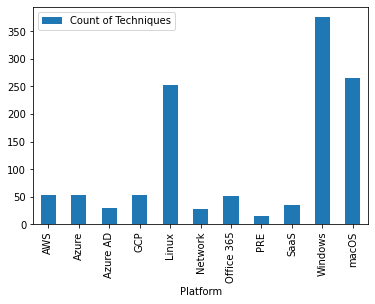

In [ ]:
#Let's create a visualization to show the number of techniques grouped by platform:
platform_distribution = pd.DataFrame({
    'Platform': list(techniques_platform_2.groupby(['platform'])['platform'].count().keys()),
    'Count of Techniques': techniques_platform_2.groupby(['platform'])['platform'].count().tolist()})

#Show in graph
platform_distribution.plot(kind="bar", x='Platform', y ='Count of Techniques')
plt.show()

In [ ]:
#Grouping techniques with Data Source
techniques_data_source=techniques_with_data_sources

attributes_3 = ['data_sources'] # In attributes we are going to indicate the name of the columns that we need to split

for a in attributes_3:
    s = techniques_data_source.apply(lambda x: pd.Series(x[a]),axis=1).stack().reset_index(level=1, drop=True)
    # "s" is going to be a column of a frame with every value of the list inside each cell of the column "a"
    s.name = a
    # We name "s" with the same name of "a".
    techniques_data_source = techniques_data_source.drop(a, axis=1).join(s).reset_index(drop=True)
    # We drop the column "a" from "techniques_data_source", and then join "techniques_data_source" with "s"

# Let's re-arrange the columns from general to specific
techniques_data_source_2 = techniques_data_source.reindex(['matrix','platform','tactic','technique','technique_id','data_sources'], axis=1)

# We are going to edit some names inside the dataframe to improve the consistency:
techniques_data_source_3 = techniques_data_source_2.replace(['Process monitoring','Application logs'],['Process Monitoring','Application Logs'])


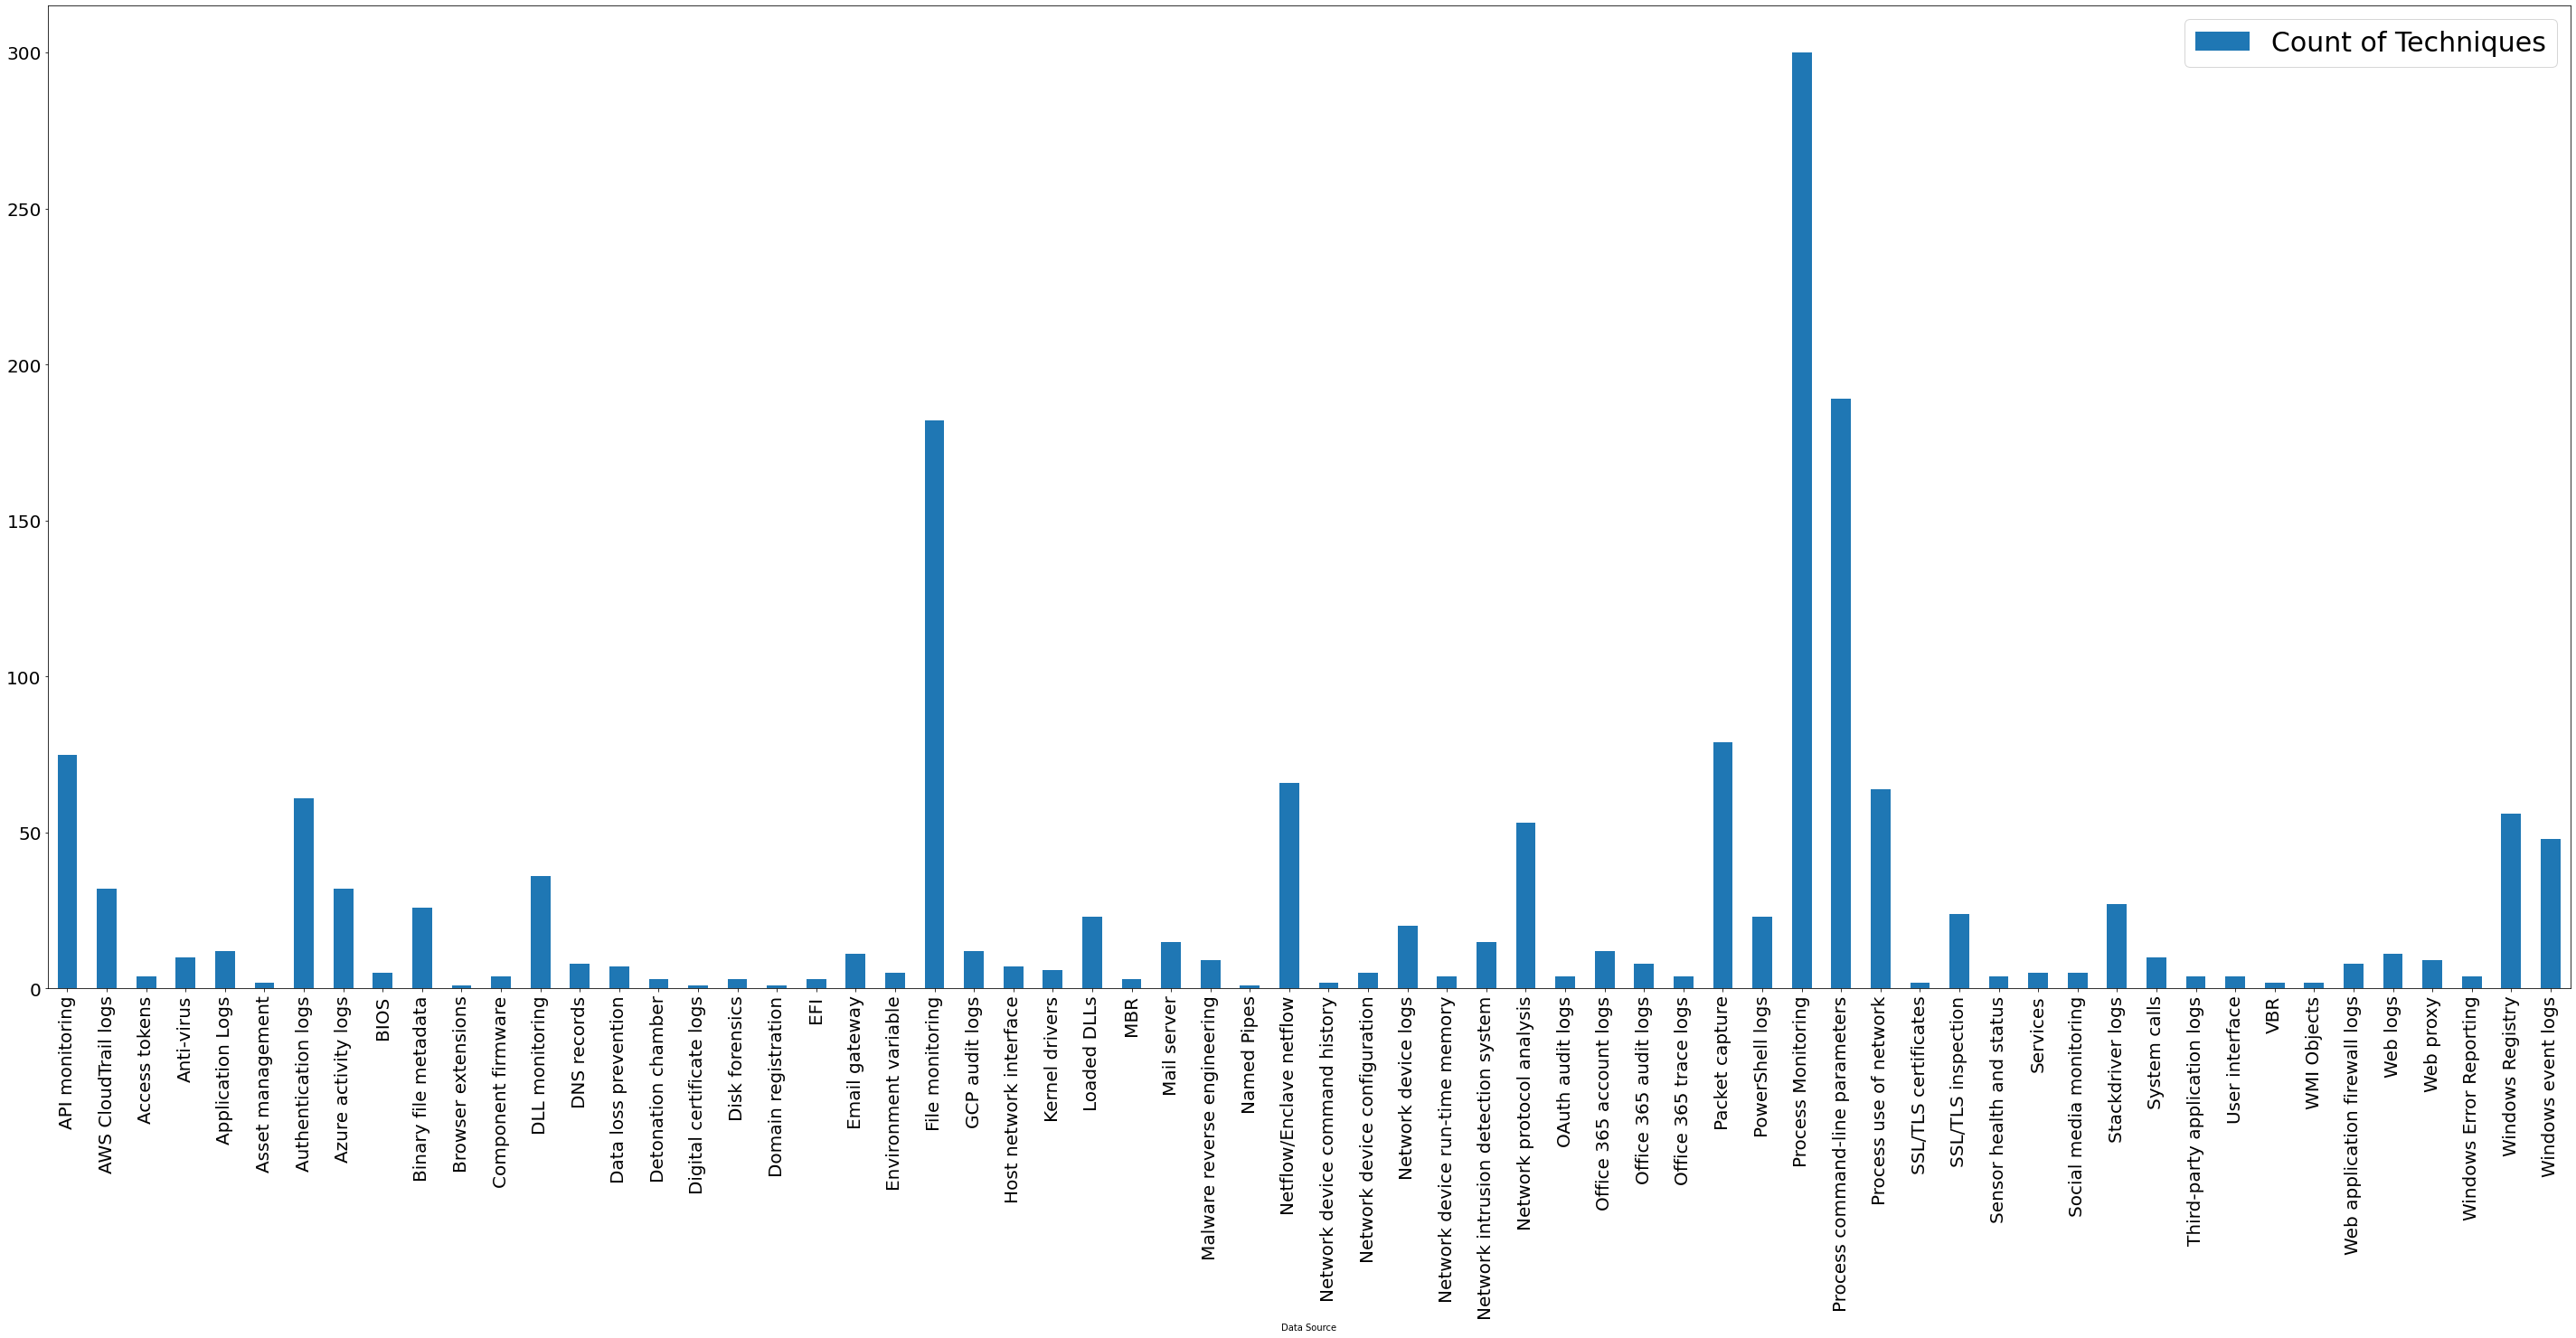

In [ ]:
#Show in Graphs

data_source_distribution = pd.DataFrame({
    'Data Source': list(techniques_data_source_3.groupby(['data_sources'])['data_sources'].count().keys()),
    'Count of Techniques': techniques_data_source_3.groupby(['data_sources'])['data_sources'].count().tolist()})


#Show in graph
data_source_distribution.plot(figsize=(50,20), kind="bar", x='Data Source', y ='Count of Techniques', fontsize=20).legend(fontsize=30)
plt.show()
